In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, reset_output, curdoc
from bokeh.embed import file_html
from bokeh.models import LabelSet, Label, ColumnDataSource, FactorRange, HoverTool
from bokeh.models.annotations import Title
from bokeh.transform import factor_cmap
import bokeh.plotting as bp
from bokeh.layouts import row, column,layout, gridplot
from bokeh.models.widgets import Slider, TextInput
from bokeh.transform import cumsum
from bokeh.palettes import Category10
import nltk
reset_output()
output_notebook()

Loading BokehJS ...

### Gráfico final

In [48]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, reset_output, curdoc
from bokeh.embed import file_html
from bokeh.models import LabelSet, Label, ColumnDataSource, FactorRange, HoverTool
from bokeh.models.annotations import Title
from bokeh.transform import factor_cmap
import bokeh.plotting as bp
from bokeh.layouts import row, column,layout, gridplot
from bokeh.models.widgets import Slider, TextInput, RangeSlider, Select
from bokeh.transform import cumsum
from bokeh.palettes import Category10, Category20
import nltk

#Se cargan los datos
data = pd.read_csv("./data/data_procesada.csv", parse_dates=True, infer_datetime_format=True)
data = data.set_index("time")
data.index = pd.to_datetime(data.index)

data_norm = pd.read_csv("./data/data_geral_normalizada.csv", parse_dates=True, infer_datetime_format=True)
data_norm = data_norm.set_index("time")
data_norm.index = pd.to_datetime(data_norm.index)

def histogram(df, col, bins=30):
    edges = []
    hist = []
    largura = max(df.index) - min(df.index)
    h = largura/bins
    aux = min(df.index)
    for i in range(bins):
        edges.append(aux)
        hist.append(df.loc[aux:aux + h].count()[col])
        aux = aux + h
    edges.append(aux)
    
    return edges, hist

#Distribução geral dos dados
p1 = figure(plot_height=300, plot_width=800, title="Quantidade de tweets por intervalo de tempo para todos os bairros",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_axis_type='datetime')
p1.xaxis.axis_label = "dias registrados"
p1.yaxis.axis_label = "quantidade de tweets"
#quantidade de tweets por bairro
p2 = figure(plot_height=300, plot_width=300, title="Quantidade de tweets por bairro",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_range=(-4,4), y_range=(-4,4))
#disribuição normalizada
p3 = figure(plot_height=300, plot_width=795, title="Quantidade de tweets por bairro normaliada",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_axis_type='datetime', x_range=p1.x_range)
p3.xaxis.axis_label = "dias registrados"
p3.yaxis.axis_label = "quantidade de tweets"
#distribuição dos dados por intervalo em cada bairro
p4 = figure(plot_height=300, plot_width=600, title="Quantidade geral de tweets no intervalo",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_axis_type='datetime', x_range=p5.x_range)
 
p5 = figure(plot_height=300, plot_width=600, title="Quantidade de tweets por bairro no intervalo",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_axis_type='datetime')
#quantidade de tweets por bairro no intervalo
p6 = figure(plot_height=300, plot_width=300, title="Quantidade de tweets por bairro no intervalo",
           tools="hover,pan,wheel_zoom,box_zoom,reset,save",x_range=(-4,4), y_range=(-4,4))

names = ["Palace Hills", "Northwest", "Old Town", "Safe Town", "Southwest", "Downtown",
         "Wilson Forest", "Scenic Vista", "Broadview", "Chapparal", "Terrapin Springs",
         "Pepper Mill", "Cheddarford", "Easton", "Weston", "Southton", "Oak Willow",
         "East Parton", "West Parton"]
#Barras de interacción
bairro_init = "Palace Hills"
select_vec = Select(title="Bairro:", value=bairro_init, options=names)
s_tipo = Select(title="horas depois do terremoto:", value="5", options=["5","30"])
#histograma geral sem normalizar
edges1, hist1 = histogram(data, "location", bins=100)
source1 = ColumnDataSource(dict(hist=hist1,left=edges1[:-1], right=edges1[1:]))
p1.quad(top="hist", bottom=0, left="left", right="right", color = "blue",
            line_color="white", alpha=0.7, source=source1, legend="tweets")
p1.hover.tooltips = [("data inicial", "@left{%F %T}"),
                    ("data final", "@right{%F %T}"),
                    ("quantidade", "@hist")]
p1.hover.formatters = {'left': 'datetime', 'right': 'datetime'}
p1.hover.mode = "vline"

#histograma geral normalizado
edges2, hist2 = histogram(data_norm.loc[data_norm.location==bairro_init], "location", bins=100)
source2 = ColumnDataSource(dict(hist=hist2,left=edges2[:-1], right=edges2[1:]))
p3.quad(top="hist", bottom=0, left="left", right="right", color = "red",
            line_color="white", alpha=0.7, source=source2, legend="tweets")
p3.hover.tooltips = [("data inicial", "@left{%F %T}"),
                    ("data final", "@right{%F %T}"),
                    ("quantidade", "@hist")]
p3.hover.formatters = {'left': 'datetime', 'right': 'datetime'}
p3.hover.mode = "vline"

#Diagrama de pizza da cuantidade de chamadas por bairro
data_aux = data.copy()
data_aux.drop(["account","message"], axis=1)
data_aux["values"] = 1
data_aux = data_aux.groupby("location").sum()
data_aux = data_aux.drop(["UNKNOWN", "<Location with-held due to contract>"])
source3 = ColumnDataSource(dict(data_aux, angle=data_aux["values"]/(data_aux["values"]).sum() * 2*np.pi,
                                  color=Category20[19], location=data_aux.index))
p2.wedge(x=0, y=0, radius=3,start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
         line_color="black", fill_color='color', source=source3)
p2.hover.tooltips = [("bairro", "@location"),
                     ("quantidade", "@values")]

#histograma geral normalizado no intervalo de 5h até 30h depois do terremoto "2020-04-06 19:40:00":"2020-04-07 20:40:00"
data4 = data_norm.loc["2020-04-06 14:40:00":"2020-04-06 19:40:00"]
edges4, hist4 = histogram(data4,"location", bins=int(1+3.3*np.log(data4.shape[0])))
source4 = ColumnDataSource(dict(hist=hist4,left=edges4[:-1], right=edges4[1:]))
p4.quad(top="hist", bottom=0, left="left", right="right", color = "orange",
            line_color="white", alpha=0.8, source=source4, legend="tweets")
p4.hover.tooltips = [("data inicial", "@left{%F %T}"),
                    ("data final", "@right{%F %T}"),
                    ("quantidade", "@hist")]
p4.hover.formatters = {'left': 'datetime', 'right': 'datetime'}
p4.hover.mode = "vline"

#histograma por bairro normalizado no intervalo de 5h até 30h depois do terremoto

data5 = data_norm.loc[data_norm.location==bairro_init].loc["2020-04-06 14:40:00":"2020-04-06 19:40:00"]
edges5, hist5 = histogram(data5,"location", bins=int(1+3.3*np.log(data5.shape[0])))
source5 = ColumnDataSource(dict(hist=hist5,left=edges5[:-1], right=edges5[1:]))
p5.quad(top="hist", bottom=0, left="left", right="right", color = "green",
            line_color="white", alpha=0.8, source=source5, legend="tweets")
p5.hover.tooltips = [("data inicial", "@left{%F %T}"),
                    ("data final", "@right{%F %T}"),
                    ("quantidade", "@hist")]
p5.hover.formatters = {'left': 'datetime', 'right': 'datetime'}
p5.hover.mode = "vline"

#Diagrama de pizza da cuantidade de chamadas por bairro no intervalo
data6 = data_norm.loc["2020-04-06 14:40:00":"2020-04-06 19:40:00"].copy()
data6.drop(["account","message"], axis=1)
data6["values"] = 1
data6 = data6.groupby("location").sum()
#verificar sim todas as ciudades estão no index, sim não é assim, se adiciona com um valor de 1
for name in names:
    if not(name in data6.index):
        data6.loc[name] = 1
for idx in ["UNKNOWN", "<Location with-held due to contract>"]:
    if idx in data6.index:
        data6 = data6.drop(idx)
source6 = ColumnDataSource(dict(data6, angle=data6["values"]/(data6["values"]).sum() * 2*np.pi,
                                  color=Category20[19], location=data6.index))
p6.wedge(x=0, y=0, radius=3,start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
         line_color="black", fill_color='color', source=source6)
p6.hover.tooltips = [("bairro", "@location"),
                     ("quantidade", "@values")]

def update_data(attrname, old, new):
    #Para obtener los valores actuales
    vec_val = select_vec.value
    #hr_val = s_range.value
    ht = s_tipo.value
    #Atualizar grafico 3
    edges2, hist2 = histogram(data_norm.loc[data_norm.location==vec_val], "location", bins=100)
    source2.data = dict(hist=hist2,left=edges2[:-1], right=edges2[1:])
    #Atualizar gráfico4
    if ht == "5":
        data4 = data_norm.loc["2020-04-06 14:40:00":"2020-04-06 19:40:00"]
        data5 = data_norm.loc[data_norm.location==vec_val].loc["2020-04-06 14:40:00":"2020-04-06 19:40:00"]
    else:
        data4 = data_norm.loc["2020-04-06 14:40:00":"2020-04-07 20:40:00"]
        data5 = data_norm.loc[data_norm.location==vec_val].loc["2020-04-06 14:40:00":"2020-04-07 20:40:00"]
    edges4, hist4 = histogram(data4,"location", bins=int(1+3.3*np.log(data4.shape[0])))
    source4.data = dict(hist=hist4,left=edges4[:-1], right=edges4[1:])
    #Atualizar gŕafico5
    edges5, hist5 = histogram(data5,"location", bins=int(1+3.3*np.log(data5.shape[0])))
    source5.data = dict(hist=hist5,left=edges5[:-1], right=edges5[1:])
    #Atualizar gráfico6
    data6 = data4.copy()
    data6.drop(["account","message"], axis=1)
    data6["values"] = 1
    data6 = data6.groupby("location").sum()
    #verificar sim todas as ciudades estão no index, sim não é assim, se adiciona com um valor de 1
    for name in names:
        if not(name in data6.index):
            data6.loc[name] = 1
    for idx in ["UNKNOWN", "<Location with-held due to contract>"]:
        if idx in data6.index:
            data6 = data6.drop(idx)
    source6.data = dict(data6, angle=data6["values"]/(data6["values"]).sum() * 2*np.pi,
                                      color=Category20[19], location=data6.index)
    
#Para hacer las actualizaciones
for w in [select_vec, s_tipo]:
    w.on_change('value', update_data)

inputs = column([select_vec, s_tipo], width=200)
vzio = column(width=210)
row_1 = row([inputs, p1, p2], width=1100)
row_2 = row([vzio, p3, p6])
row_3 = row([p4, p5])
row_4 = row([])

curdoc().add_root(row(gridplot([[row_1],[row_2],[row_3],[row_4]]), width=400))


### WordCloud

In [50]:
c_power = ["power", "energy", "electric", "electrician", "electricity", "powerlines", "electric", "radiation",
          "reactor"]
c_shake = ["shake", "earthquake", "quake", "tremble", "rubble", "earthquakes", "earthqwakes", "earthqwake", 
           "vibrate"]
c_hospital = ["hospital", "hospitals", "die", "dead", "death", "health"]
c_disaster = ["disaster", "disasters"]
c_sewer = ["sewer", "sewage"]
c_evacuation = ["evacuation", "evacuate"]
others = ["nuclear", "repair", "structutral", "rescue", "emergency", "dangerous", "problem", "problems", "cry",
          "apocalypse", "sad", "ambulance", "victims", "help", "tragedy", "destroy", "roads", "scar", "hazard",
          "bridge", "damage", "build", "crew", "shudder", "incident", "wobble", "risk"]

p_usar = c_power + c_shake + c_hospital + c_disaster + c_sewer + c_evacuation + others

In [51]:
list_palavras = ""
bairro= "Weston"
l = []
dbairro = data.loc[data.location==bairro]
for idx, cor in dbairro.iterrows():
    for word in p_usar:
        if word in cor.message:
            if word in c_power:
                list_palavras = list_palavras + " " + "power"
            elif word in c_shake:
                list_palavras = list_palavras + " " + "earthquake"
            elif word in c_hospital:
                list_palavras = list_palavras + " " + "hospital"
            elif word in c_disaster:
                list_palavras = list_palavras + " " + "disaster"
            elif word in c_hospital:
                list_palavras = list_palavras + " " + "hospital"
            elif word in c_sewer:
                list_palavras = list_palavras + " " + "sewer"
            else:
                list_palavras = list_palavras + " " + word
            l.append(word)

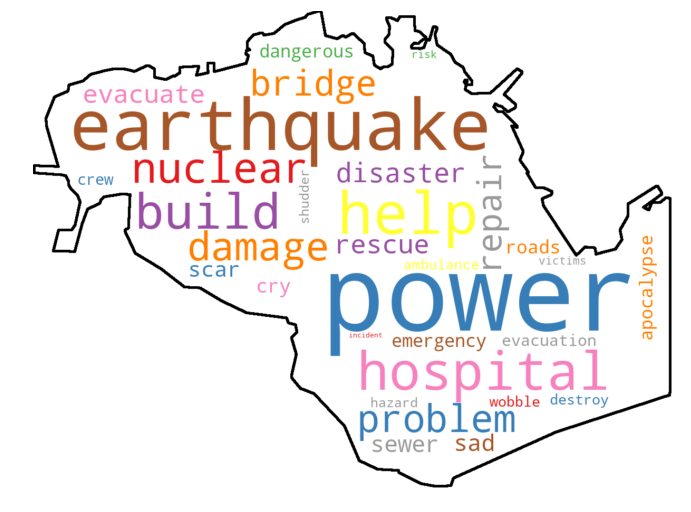

In [55]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wine_mask = np.array(Image.open("map_white.png"))
 
wordcloud = WordCloud(max_font_size=200, max_words=50, mode='RGB',mask=wine_mask,colormap=plt.cm.Set1,
                      collocations=False, contour_width=8, relative_scaling=.5,
                      background_color="white").generate(list_palavras)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()